In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import plotly.express as px


import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('./data/data_NO2.csv', sep=';')
data['datetime_utc'] = pd.to_datetime(data['datetime_utc'], infer_datetime_format=True)
data.set_index('datetime_utc', inplace=True)
data.sort_values(by='datetime_utc', inplace=True)
data.head()

,volume_demand,volume_production,spot_price
datetime_utc,,,
2015-12-31 23:00:00+00:00,4043.0,7818.0,16.39
2016-01-01 00:00:00+00:00,4010.0,7694.0,16.04
2016-01-01 01:00:00+00:00,3930.0,7437.0,15.74
2016-01-01 02:00:00+00:00,3839.0,7120.0,15.57
2016-01-01 03:00:00+00:00,3833.0,7041.0,15.47


In [3]:
data.tail()

,volume_demand,volume_production,spot_price
datetime_utc,,,
2018-09-12 22:00:00+00:00,3399.0,4843.0,50.53
2018-09-12 23:00:00+00:00,3287.0,4840.0,50.12
2018-09-13 00:00:00+00:00,3228.0,4769.0,50.12
2018-09-13 01:00:00+00:00,3274.0,4889.0,50.65
2018-09-13 02:00:00+00:00,3333.0,5025.0,51.81


## Modeling without additional features

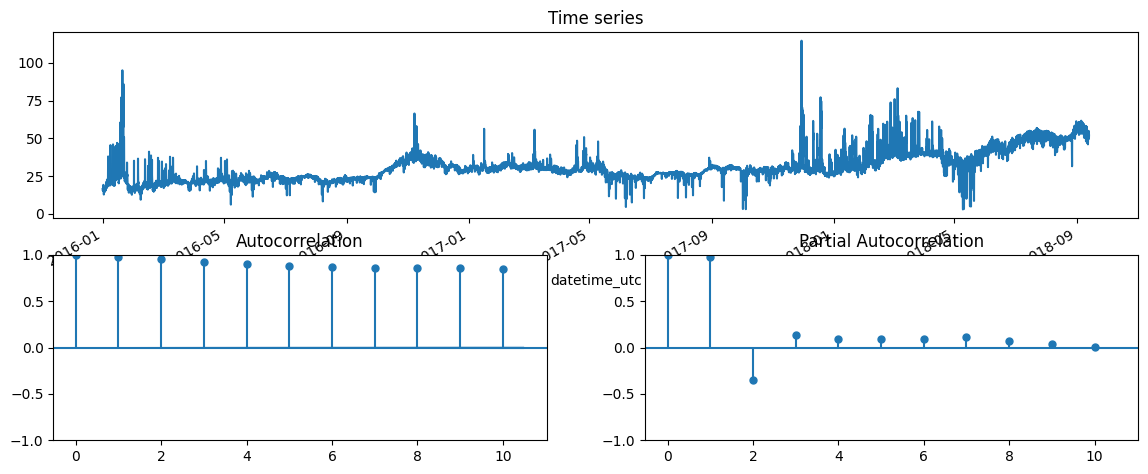

In [4]:
DAYS_TO_PLOT = 30
# 14 days of data before last date
TEST_SPLIT_DATE = data.index[-1] - pd.Timedelta(days=DAYS_TO_PLOT)

def tsplot(y, lags=15):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    
    # layout
    fig = plt.figure(figsize=(14, 6))
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    # ts plot
    y.plot(ax=ts_ax)
    ts_ax.set_title('Time series')
    
    # acf, pacf
    plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
    plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5, method='ywm')

tsplot(data['spot_price'], lags=10)

In [5]:
df = data[['spot_price']].copy()
df_train = df[df.index < TEST_SPLIT_DATE]
df_test = df[df.index >= TEST_SPLIT_DATE]

#### Computing neccessary parameters for ARMA models
This function identifies the order of an ARMA process, provided that the time series is stationary and invertible. This function computes the full exact MLE estimate of each model (https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.arma_order_select_ic.html)

In [6]:
arma_order_select_ic(df_train, ic='aic', trend='n')

{'aic':                0              1              2
 0  223404.505420  192807.559457  167422.827594
 1   93328.503545   90163.930820   90099.872338
 2   90465.634949   90121.963574   90081.690041
 3   89933.660500   87830.153662   90017.787466
 4   89695.479391   87829.292908            NaN,
 'aic_min_order': (4, 2)}

In [7]:
model = ARIMA(df_train, order=(4,1,2), trend='n')
res = model.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:             spot_price   No. Observations:                22945
Model:                 ARIMA(4, 1, 2)   Log Likelihood              -43899.929
Date:                Wed, 13 Nov 2024   AIC                          87813.857
Time:                        15:12:02   BIC                          87870.143
Sample:                             0   HQIC                         87832.150
                              - 22945                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6035      0.087      6.917      0.000       0.432       0.774
ar.L2          0.3453      0.110      3.138      0.002       0.130       0.561
ar.L3         -0.2582      0.041     -6.296      0.0

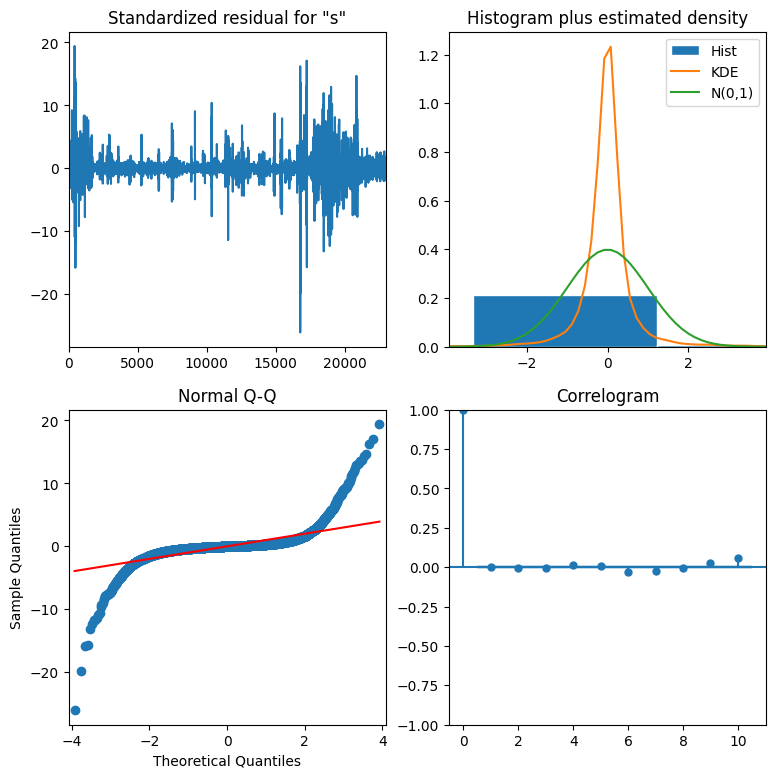

In [8]:
res.plot_diagnostics(figsize=(9,9))
plt.show()

In [9]:
def plot_predictions(preds, df, df_test):
    # Create a Plotly figure for the actual data
    
    fig = px.line(df, x=df.index, y='spot_price', title='Spot Price')
    # Add the test data to the plot
    fig.add_scatter(x=df_test.index, y=df_test['spot_price'], name='Test Data', line=dict(color='green'), mode='lines')

    fig.update_xaxes(title_text='Date')
    fig.update_yaxes(title_text='Price (EUR)')
    fig.update_layout(width=1200, height=700)

    # Add predictions to the plot
    fig.add_scatter(x=preds.index, y=preds['mean'], name='Prediction', line=dict(color='orange'), mode='lines')
    fig.add_scatter(x=preds.index, y=preds['mean_ci_lower'], name='Lower CI', line=dict(color='gray'), mode='lines', fill='tonexty')
    fig.add_scatter(x=preds.index, y=preds['mean_ci_upper'], name='Upper CI', line=dict(color='gray'), mode='lines', fill='tonexty')
    # set fig size
    fig.update_layout(width=1000, height=500)
    fig.show()



In [10]:
offset = 4
start_idx = df_train.shape[0] - 24 * offset
end_idx = start_idx + DAYS_TO_PLOT * 24 - 1

predictions = res.get_prediction(start=start_idx, end=end_idx, dynamic=False).summary_frame()
# last timestamp is index at start_idx
last_timestamp = df_train.index[start_idx]
predictions.index = pd.date_range(start=last_timestamp, periods=DAYS_TO_PLOT*24, freq='H')

In [11]:
plot_predictions(predictions, df_train.last(f'{offset}d'), df_test.first(f'{DAYS_TO_PLOT-offset}d'))

In [12]:
from sklearn.metrics import mean_squared_error

In [88]:
# index of TEST_SPLIT_DATE in df
split_idx = df.index.get_loc(TEST_SPLIT_DATE)
diff = df.shape[0] - split_idx
preds = res.get_prediction(start=split_idx, end=split_idx+diff-1).summary_frame()
rmse = mean_squared_error(df_test['spot_price'], preds['mean'], squared=False)
print(f'RMSE: {rmse:.2f} EUR')

RMSE: 6.36 EUR


In [89]:
mae = mean_absolute_error(df_test['spot_price'], preds['mean'])
print(f'MAE: {mae:.2f} EUR')

MAE: 5.20 EUR


### Seasonal Naive
this method naively uses the previous intervals' numbers for prediction.

Combined Seasonal Naive RMSE 24h forward: 2.51 EUR
Combined Seasonal Naive RMSE 168h forward: 3.94 EUR


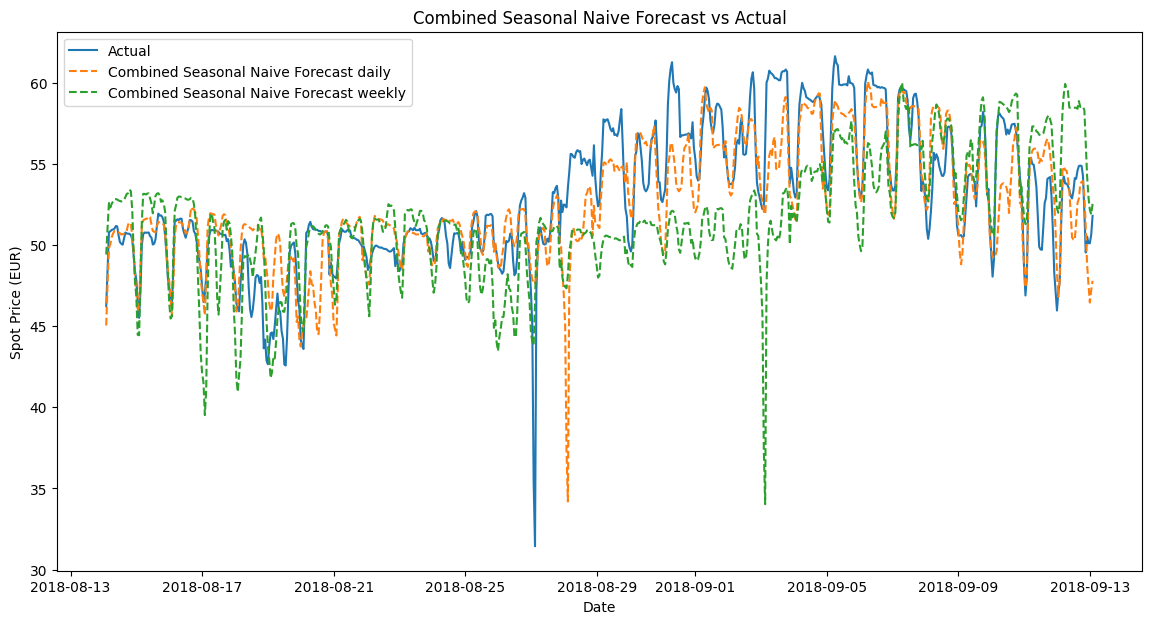

In [14]:
# Define the season lengths for daily and weekly seasonality
daily_season_length = 24
weekly_season_length = 24 * 7
monthly_season_length = 24 * 30

daily_seasonal_naive_preds = df['spot_price'].shift(daily_season_length)
weekly_seasonal_naive_preds = df['spot_price'].shift(weekly_season_length)
monthly_seasonal_naive_preds = df['spot_price'].shift(monthly_season_length)

# weights  #d    #w    #m
weights_24 =  [0.80, 0.05, 0.15] # weights chosen based on intuition
weights_168 = [0.0, 0.85, 0.15] # weights chosen based on intuition
# preds 
preds = [daily_seasonal_naive_preds, weekly_seasonal_naive_preds, monthly_seasonal_naive_preds]

# Combine the daily and weekly forecasts
combined_seasonal_naive_preds_24 = sum([w * p for w, p in zip(weights_24, preds)])
combined_seasonal_naive_preds_168 = sum([w * p for w, p in zip(weights_168, preds)])

# Extract the test period predictions
combined_seasonal_naive_preds_test_24 = combined_seasonal_naive_preds_24.loc[df_test.index]
combined_seasonal_naive_preds_test_168 = combined_seasonal_naive_preds_168.loc[df_test.index]

# Calculate RMSE for the combined seasonal naive forecast
combined_seasonal_naive_rmse_24 = mean_squared_error(df_test['spot_price'], combined_seasonal_naive_preds_test_24, squared=False)
combined_seasonal_naive_rmse_168 = mean_squared_error(df_test['spot_price'], combined_seasonal_naive_preds_test_168, squared=False)
print(f'Combined Seasonal Naive RMSE 24h forward: {combined_seasonal_naive_rmse_24:.2f} EUR')
print(f'Combined Seasonal Naive RMSE 168h forward: {combined_seasonal_naive_rmse_168:.2f} EUR')

# Plot the combined seasonal naive forecast
plt.figure(figsize=(14, 7))
plt.plot(df_test.index, df_test['spot_price'], label='Actual')
plt.plot(df_test.index, combined_seasonal_naive_preds_test_24, label='Combined Seasonal Naive Forecast daily', linestyle='--')
plt.plot(df_test.index, combined_seasonal_naive_preds_test_168, label='Combined Seasonal Naive Forecast weekly', linestyle='--')
plt.legend()
plt.title('Combined Seasonal Naive Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Spot Price (EUR)')
plt.show()

## Tree models

In [15]:
from lightgbm import LGBMRegressor as lgr
import lightgbm as lgb
#from catboost import CatBoostRegressor as cbr
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso,LinearRegression,Ridge,ElasticNet
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder,StandardScaler,RobustScaler,MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV , StratifiedKFold
from sklearn.metrics import explained_variance_score,r2_score,mean_squared_error,mean_absolute_error

## Features

In [16]:
data['hour'] = data.index.hour
data['weekday'] = data.index.weekday
data['day'] = data.index.day
data['month'] = data.index.month
data['year'] = data.index.year

In [17]:
data['weekend'] = data['weekday'].apply(lambda x: 1 if x > 4 else 0).astype(int)
data['working_hours'] = data['hour'].apply(lambda x: 1 if 8 <= x <= 17 else 0).astype(int)
data['night'] = data['hour'].apply(lambda x: 1 if 0 <= x <= 6 else 0).astype(int)
data['morning'] = data['hour'].apply(lambda x: 1 if 7 <= x <= 11 else 0).astype(int)
data['afternoon'] = data['hour'].apply(lambda x: 1 if 12 <= x <= 16 else 0).astype(int)
data['evening'] = data['hour'].apply(lambda x: 1 if 17 <= x <= 23 else 0).astype(int)

In [18]:
for x in [1,12,24,48,72]:
    data[f'lagged_prod_{x}'] = data['volume_production'].shift(x).bfill()
    data[f'lagged_demand_{x}'] = data['volume_demand'].shift(x).bfill()
    data[f'lagged_price_{x}'] = data['spot_price'].shift(x).bfill()

In [19]:
# build some rolling features like rolling mean
data['rolling_mean_prod_4'] = data['volume_production'].rolling(window=4).mean().bfill()
data['rolling_mean_prod_24'] = data['volume_production'].rolling(window=24).mean().bfill()

data['rolling_mean_demand_4'] = data['volume_demand'].rolling(window=4).mean().bfill()
data['rolling_mean_demand_24'] = data['volume_demand'].rolling(window=24).mean().bfill()

data['rolling_mean_price_4'] = data['spot_price'].rolling(window=4).mean().bfill()
data['rolling_mean_price_24'] = data['spot_price'].rolling(window=24).mean().bfill()


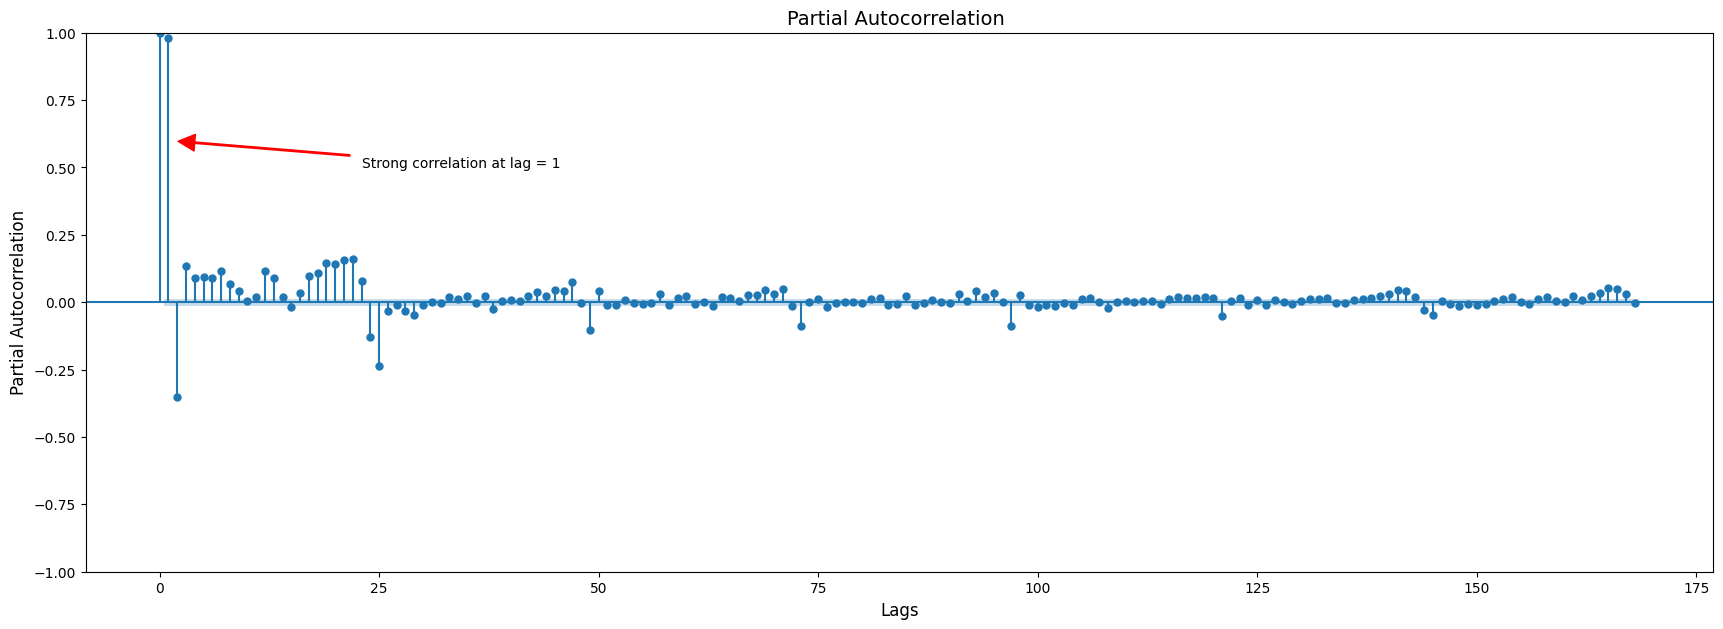

In [20]:
from statsmodels.graphics.tsaplots import plot_pacf
plt.rc("figure", figsize=(21, 7))
plot_pacf(data['spot_price'], lags=24*7)

plt.annotate('Strong correlation at lag = 1', xy=(1, 0.6),  xycoords='data', \
            xytext=(0.17, 0.75), textcoords='axes fraction', \
            arrowprops=dict(color='red', shrink=0.05, width=1))

plt.xlabel('Lags', fontsize=12)
plt.ylabel('Partial Autocorrelation', fontsize=12)
plt.title(f'Partial Autocorrelation ', fontsize=14)
plt.show()

In [21]:
features = list(data.columns)
features

['volume_demand',
 'volume_production',
 'spot_price',
 'hour',
 'weekday',
 'day',
 'month',
 'year',
 'weekend',
 'working_hours',
 'night',
 'morning',
 'afternoon',
 'evening',
 'lagged_prod_1',
 'lagged_demand_1',
 'lagged_price_1',
 'lagged_prod_12',
 'lagged_demand_12',
 'lagged_price_12',
 'lagged_prod_24',
 'lagged_demand_24',
 'lagged_price_24',
 'lagged_prod_48',
 'lagged_demand_48',
 'lagged_price_48',
 'lagged_prod_72',
 'lagged_demand_72',
 'lagged_price_72',
 'rolling_mean_prod_4',
 'rolling_mean_prod_24',
 'rolling_mean_demand_4',
 'rolling_mean_demand_24',
 'rolling_mean_price_4',
 'rolling_mean_price_24']

In [22]:
train_data = pd.DataFrame()
target_ahead_timeblocks = 8 # forecasting 2 hours ahead. 
train_data = data[features].copy()
for feature in train_data.columns:
    train_data[feature] = train_data[feature].shift(-target_ahead_timeblocks ).ffill()
print(train_data.shape)
train_data

(23666, 35)


,volume_demand,volume_production,spot_price,hour,weekday,day,month,year,weekend,working_hours,...,lagged_price_48,lagged_prod_72,lagged_demand_72,lagged_price_72,rolling_mean_prod_4,rolling_mean_prod_24,rolling_mean_demand_4,rolling_mean_demand_24,rolling_mean_price_4,rolling_mean_price_24
datetime_utc,,,,,,,,,,,,,,,,,,,,,
2015-12-31 23:00:00+00:00,4126.0,6994.0,15.19,7.0,4.0,1.0,1.0,2016.0,0.0,0.0,...,16.39,7818.0,4043.0,16.39,7022.50,8255.791667,4005.25,4327.833333,15.4175,16.619167
2016-01-01 00:00:00+00:00,4197.0,7551.0,15.39,8.0,4.0,1.0,1.0,2016.0,0.0,1.0,...,16.39,7818.0,4043.0,16.39,7098.75,8255.791667,4068.50,4327.833333,15.3275,16.619167
2016-01-01 01:00:00+00:00,4368.0,8109.0,15.78,9.0,4.0,1.0,1.0,2016.0,0.0,1.0,...,16.39,7818.0,4043.0,16.39,7411.00,8255.791667,4175.50,4327.833333,15.4325,16.619167
2016-01-01 02:00:00+00:00,4448.0,8528.0,16.15,10.0,4.0,1.0,1.0,2016.0,0.0,1.0,...,16.39,7818.0,4043.0,16.39,7795.50,8255.791667,4284.75,4327.833333,15.6275,16.619167
2016-01-01 03:00:00+00:00,4529.0,8797.0,16.50,11.0,4.0,1.0,1.0,2016.0,0.0,1.0,...,16.39,7818.0,4043.0,16.39,8246.25,8255.791667,4385.50,4327.833333,15.9550,16.619167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-12 22:00:00+00:00,3333.0,5025.0,51.81,2.0,3.0,13.0,9.0,2018.0,0.0,0.0,...,48.06,3652.0,2982.0,49.10,4880.75,5813.333333,3280.50,3722.583333,50.6750,52.906667
2018-09-12 23:00:00+00:00,3333.0,5025.0,51.81,2.0,3.0,13.0,9.0,2018.0,0.0,0.0,...,48.06,3652.0,2982.0,49.10,4880.75,5813.333333,3280.50,3722.583333,50.6750,52.906667
2018-09-13 00:00:00+00:00,3333.0,5025.0,51.81,2.0,3.0,13.0,9.0,2018.0,0.0,0.0,...,48.06,3652.0,2982.0,49.10,4880.75,5813.333333,3280.50,3722.583333,50.6750,52.906667


In [23]:
train_data['target'] = train_data['spot_price'].shift(-target_ahead_timeblocks).ffill()
train_data.head()

,volume_demand,volume_production,spot_price,hour,weekday,day,month,year,weekend,working_hours,...,lagged_prod_72,lagged_demand_72,lagged_price_72,rolling_mean_prod_4,rolling_mean_prod_24,rolling_mean_demand_4,rolling_mean_demand_24,rolling_mean_price_4,rolling_mean_price_24,target
datetime_utc,,,,,,,,,,,,,,,,,,,,,
2015-12-31 23:00:00+00:00,4126.0,6994.0,15.19,7.0,4.0,1.0,1.0,2016.0,0.0,0.0,...,7818.0,4043.0,16.39,7022.50,8255.791667,4005.25,4327.833333,15.4175,16.619167,18.53
2016-01-01 00:00:00+00:00,4197.0,7551.0,15.39,8.0,4.0,1.0,1.0,2016.0,0.0,1.0,...,7818.0,4043.0,16.39,7098.75,8255.791667,4068.50,4327.833333,15.3275,16.619167,19.11
2016-01-01 01:00:00+00:00,4368.0,8109.0,15.78,9.0,4.0,1.0,1.0,2016.0,0.0,1.0,...,7818.0,4043.0,16.39,7411.00,8255.791667,4175.50,4327.833333,15.4325,16.619167,18.68
2016-01-01 02:00:00+00:00,4448.0,8528.0,16.15,10.0,4.0,1.0,1.0,2016.0,0.0,1.0,...,7818.0,4043.0,16.39,7795.50,8255.791667,4284.75,4327.833333,15.6275,16.619167,17.93
2016-01-01 03:00:00+00:00,4529.0,8797.0,16.50,11.0,4.0,1.0,1.0,2016.0,0.0,1.0,...,7818.0,4043.0,16.39,8246.25,8255.791667,4385.50,4327.833333,15.9550,16.619167,17.69


In [24]:
valid_cutoff_date = '2018-04-01 00:00:00' # Validation Cut Off
test_cutoff = '2018-07-01 00:00:00'  # Test Cut off 
train_data = train_data.reset_index()
x = train_data.drop('target',axis=1).copy()
y = train_data.reset_index()[['datetime_utc','target']].copy()

In [25]:
x_train = x[x['datetime_utc'] < valid_cutoff_date].iloc[:,1:].copy()
y_train = y[y['datetime_utc'] < valid_cutoff_date].iloc[:,1:].copy()
x_val = x[(x['datetime_utc']>= valid_cutoff_date) & (x['datetime_utc']< test_cutoff)].iloc[:,1:].copy()
y_val = y[(y['datetime_utc']>= valid_cutoff_date) & (y['datetime_utc']< test_cutoff)].iloc[:,1:].copy()
x_test = x[x['datetime_utc'] >= test_cutoff].iloc[:,1:].copy()
y_test = y[y['datetime_utc'] >= test_cutoff].iloc[:,1:].copy()

In [26]:
#drop nan values
x_train = x_train.dropna()
y_train = y_train.dropna()
x_val = x_val.dropna()
y_val = y_val.dropna()
x_test = x_test.dropna()
y_test = y_test.dropna()


In [27]:
print(f'x train: {x_train.shape}')
print(f'x validation: {x_val.shape}')
print(f'x test: {x_test.shape}')
print(f'y train: {y_train.shape}')
print(f'y validation: {y_val.shape}')
print(f'y test: {y_test.shape}')

x train: (19703, 35)
x validation: (2184, 35)
x test: (1779, 35)
y train: (19703, 1)
y validation: (2184, 1)
y test: (1779, 1)


In [28]:
def regression_metrics(y_test,y_pred):
    print("MAE:\t",round(mean_absolute_error(y_test,y_pred),4))
    print("MSE:\t",round(mean_squared_error(y_test,y_pred),4))
    print("RMSE:\t",round(np.sqrt(mean_squared_error(y_test,y_pred)),4))

In [ ]:
def model_validate(model, param_grid, x_train, y_train, x_test,y_test, model_name, k_folds=4, scoring='neg_mean_squared_error', fit_parameters={}):

    model_cv = GridSearchCV(model, param_grid, cv=k_folds, verbose=False, scoring= scoring, refit=True)
    model_cv.fit(x_train, y_train, **fit_parameters)
    y_train_pred = model_cv.predict(x_train)
    y_test_pred = model_cv.predict(x_test)

    print('Mean Squared Error = ', np.abs(model_cv.score(x_train, y_train)))
    print("Training metrics:")
    regression_metrics(y_train ,y_train_pred)
    
    return model_cv

In [30]:
# count NaN values
print(f'Number of NaN values in x_val: {x_test.isna().sum().sum()}')

Number of NaN values in x_val: 0


In [31]:
lasso = Lasso(alpha =0.0005, random_state=20)
param_grid = [{'alpha':[0.0005,0.001, 0.005, 0.01, 0.05, 0.03, 0.1, 0.5, 1]}]

lasso_model = model_validate(lasso, param_grid, x_train, y_train, x_test, y_test, 'Lasso',k_folds=5)

Mean Squared Error =  12.014849254798662
Training metrics:
MAE:	 1.9073
MSE:	 12.0148
RMSE:	 3.4662


In [32]:
param_grid = {'learning_rate':[0.1], 'num_iterations': [10000], 'n_estimators': [25], 'num_leaves': [40],'verbose': [-1],'colsample_bytree':[0.4], 'subsample': [0.4], 'max_depth': [9]} 
lgb_model = lgr()

In [33]:
model_lgb = model_validate(lgb_model, param_grid, x_train, y_train, x_test, y_test, 'LGBM', fit_parameters={'eval_set':[(x_val, y_val)], 'eval_metric':'rmse'})

Mean Squared Error =  6.949914644101044e-06
Training metrics:
MAE:	 0.0017
MSE:	 0.0
RMSE:	 0.0026


In [34]:
predictions= lasso_model.predict(x_test)
y_test['lasso_prediction'] = predictions
predictions= model_lgb.predict(x_test)
y_test['light_gbm_prediction'] = predictions

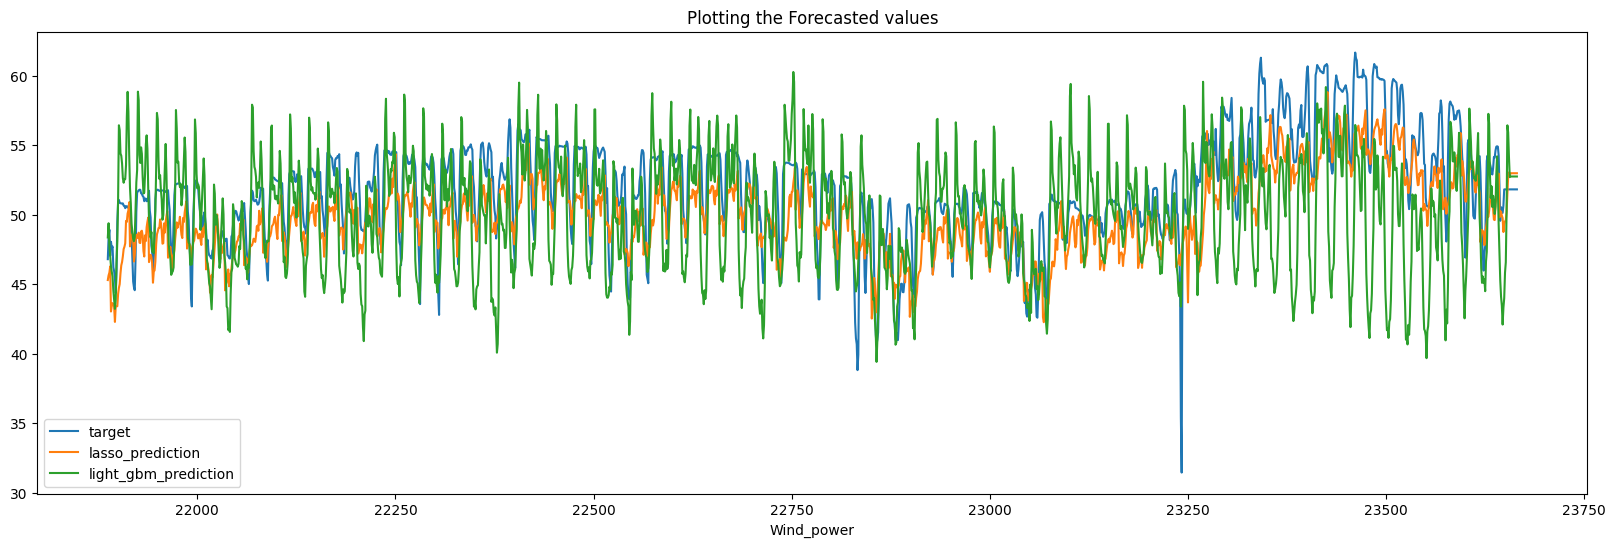

In [35]:
fig,axes = plt.subplots(1,1,figsize=(20,6))
y_test.plot(ax=axes)
plt.title('Plotting the Forecasted values')
plt.xlabel('Wind_power')
plt.show()

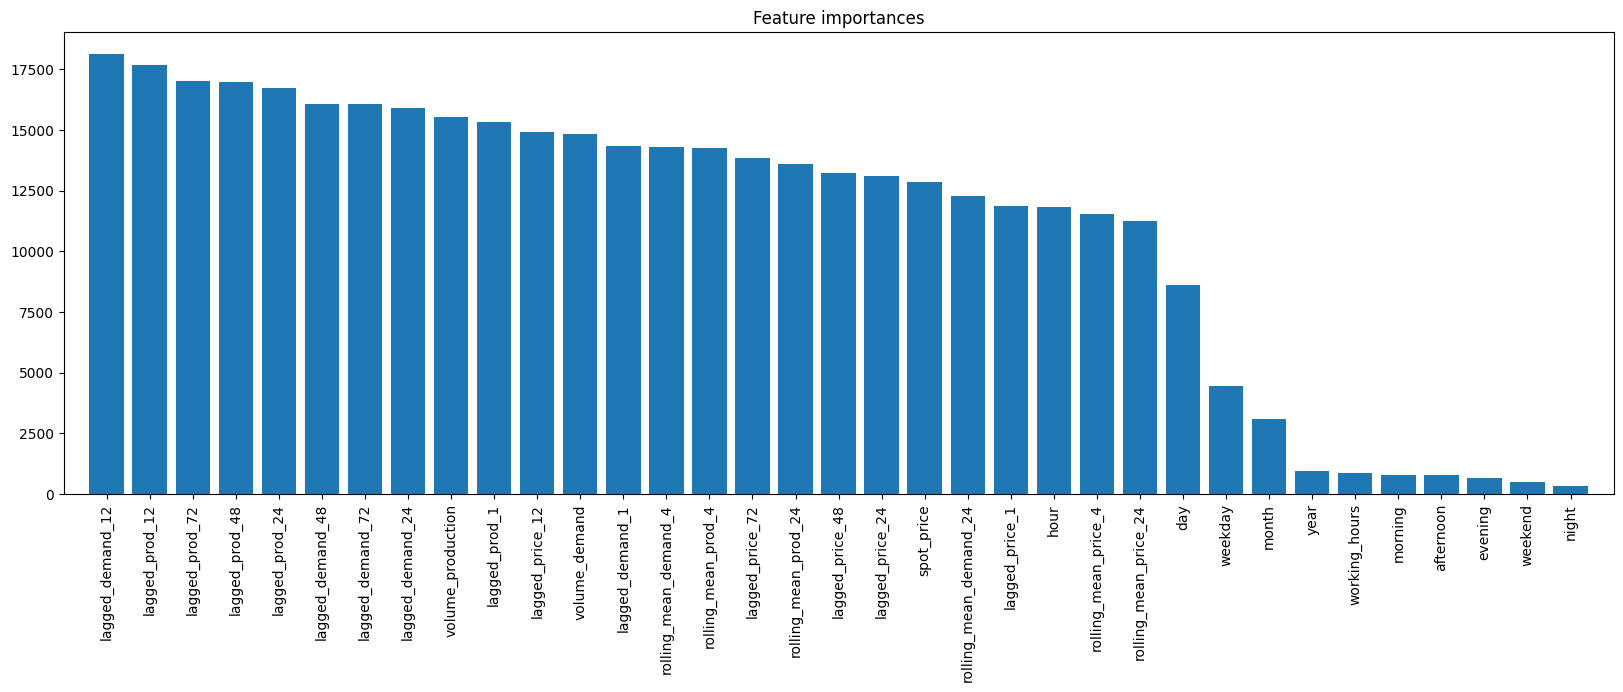

In [70]:
importances = model_lgb.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
features = x_train.columns
plt.figure(figsize=(20,6))
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices], align="center")
plt.xticks(range(x_train.shape[1]), np.array(features)[indices], rotation = 90)
plt.xlim([-1, x_train.shape[1]])
plt.show()

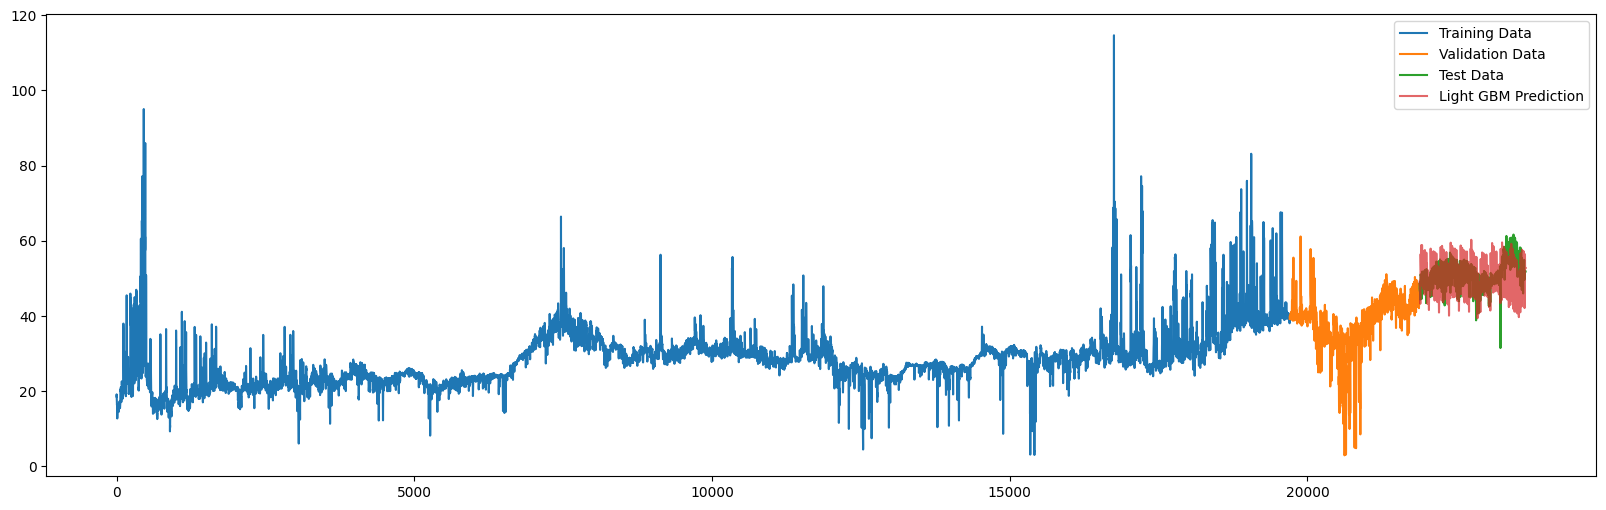

In [82]:
# plot training and test data
plt.figure(figsize=(20,6))
plt.plot(y_train, label='Training Data')
plt.plot(y_val, label='Validation Data')
plt.plot(y_test['target'], label='Test Data')
plt.plot(y_test['light_gbm_prediction'], label='Light GBM Prediction', alpha=0.7)
plt.legend()

In [84]:
# calculate the RMSE for the Light GBM model between test and pred
rmse = mean_squared_error(y_test['target'], y_test['light_gbm_prediction'], squared=False)
print(f'Light GBM RMSE: {rmse:.2f} EUR')

mae = mean_absolute_error(y_test['target'], y_test['light_gbm_prediction'])
print(f'Light GBM MAE: {mae:.2f} EUR')

Light GBM RMSE: 4.26 EUR
Light GBM MAE: 3.30 EUR


## Prophet

In [36]:
from prophet import Prophet

In [37]:
data_prophet = data[['spot_price']].copy()
data_prophet.reset_index(inplace=True)

In [38]:
# rename datetime_utc to ds and spot_price to y
data_prophet.rename(columns={'datetime_utc':'ds', 'spot_price':'y'}, inplace=True)
# remove timezone information
data_prophet['ds'] = data_prophet['ds'].dt.tz_localize(None)
data_prophet.head()

,ds,y
0,2015-12-31 23:00:00,16.39
1,2016-01-01 00:00:00,16.04
2,2016-01-01 01:00:00,15.74
3,2016-01-01 02:00:00,15.57
4,2016-01-01 03:00:00,15.47


In [39]:
train_prophet = data_prophet[data_prophet['ds'] < valid_cutoff_date].copy()
valid_prophet = data_prophet[(data_prophet['ds'] >= valid_cutoff_date) & (data_prophet['ds'] < test_cutoff)].copy()
test_prophet = data_prophet[data_prophet['ds'] >= test_cutoff].copy()

In [40]:
model = Prophet()
model.fit(data_prophet)

15:17:59 - cmdstanpy - INFO - Chain [1] start processing
15:18:15 - cmdstanpy - INFO - Chain [1] done processing


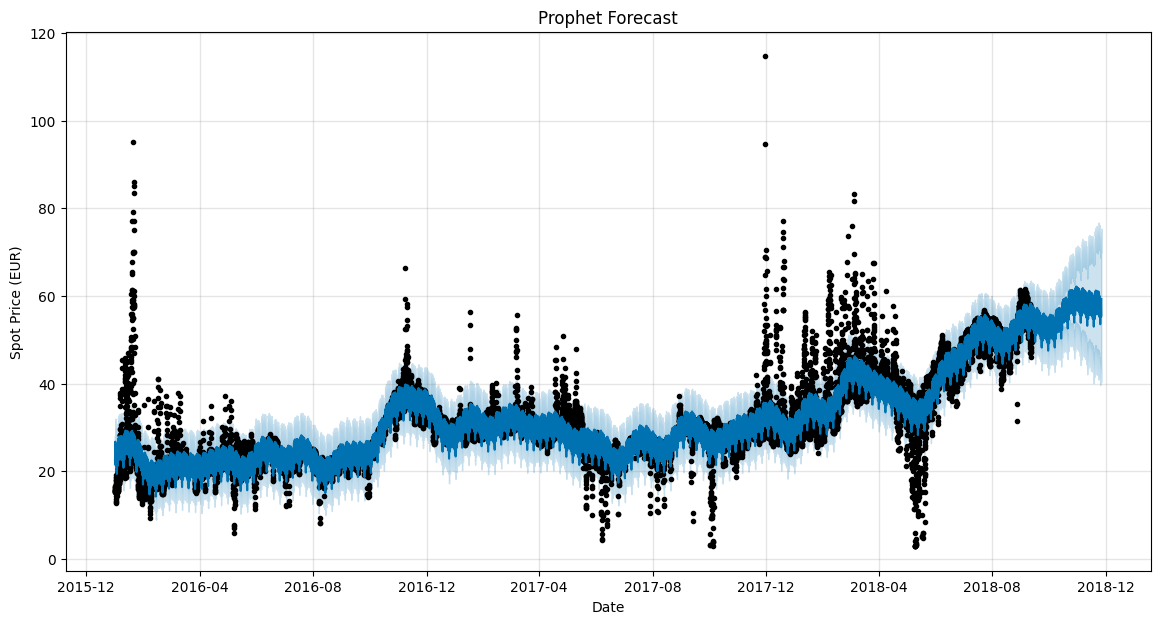

Prophet RMSE: 6.48 EUR


In [41]:
# Create predictions for the test set
future = model.make_future_dataframe(periods=len(test_prophet), freq='H')
forecast = model.predict(future)

# Plot the forecast
fig, ax = plt.subplots(figsize=(14, 7))
model.plot(forecast, ax=ax)
ax.set_title('Prophet Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Spot Price (EUR)')
plt.show()

# Calculate RMSE for the Prophet forecast
prophet_rmse = mean_squared_error(test_prophet['y'], forecast['yhat'][-len(test_prophet):], squared=False)
print(f'Prophet RMSE: {prophet_rmse:.2f} EUR')

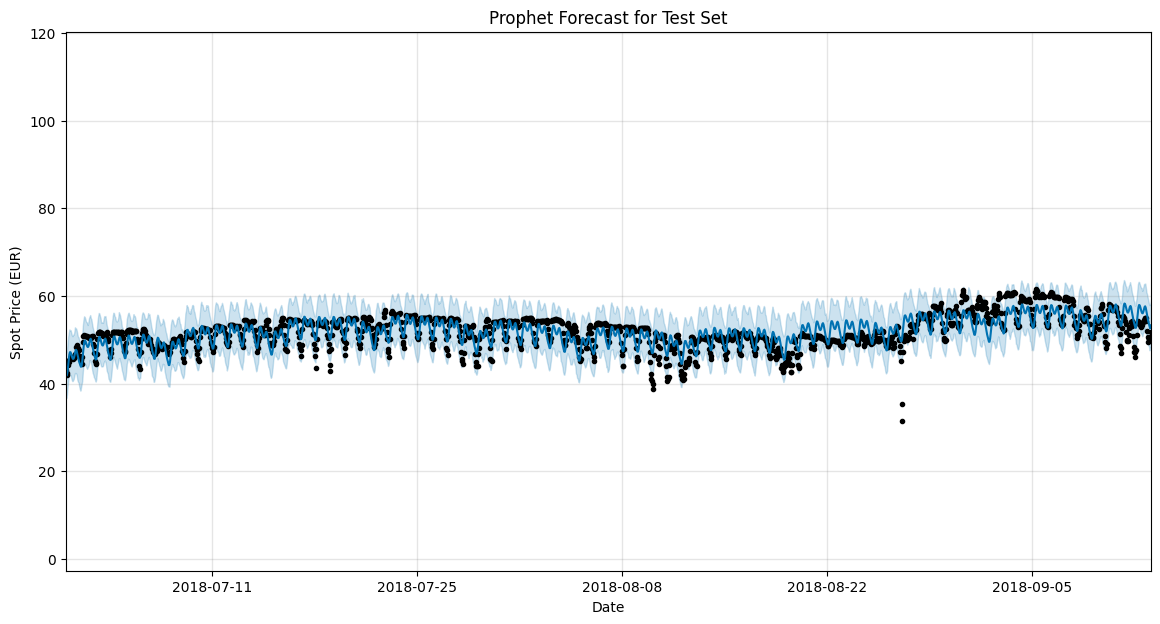

In [42]:
# Plot the forecast for the test set
fig, ax = plt.subplots(figsize=(14, 7))
model.plot(forecast, ax=ax, xlabel='Date', ylabel='Spot Price (EUR)')
ax.set_title('Prophet Forecast for Test Set')
ax.set_xlabel('Date')
ax.set_ylabel('Spot Price (EUR)')

# limit x-axis to test set period
ax.set_xlim(test_prophet['ds'].min(), test_prophet['ds'].max())

plt.show()

In [43]:
forecast_test = forecast[(forecast['ds'] >= test_prophet['ds'].min()) & (forecast['ds'] <= test_prophet['ds'].max())]

In [44]:
# calculate RMSE
rmse = mean_squared_error(test_prophet['y'], forecast_test['yhat'], squared=False)
print(f'RMSE: {rmse:.2f} EUR')

RMSE: 2.21 EUR


In [58]:
# calculate MAE
mae = mean_absolute_error(test_prophet['y'], forecast_test['yhat'])
print(f'MAE: {mae:.2f} EUR')

MAE: 1.68 EUR


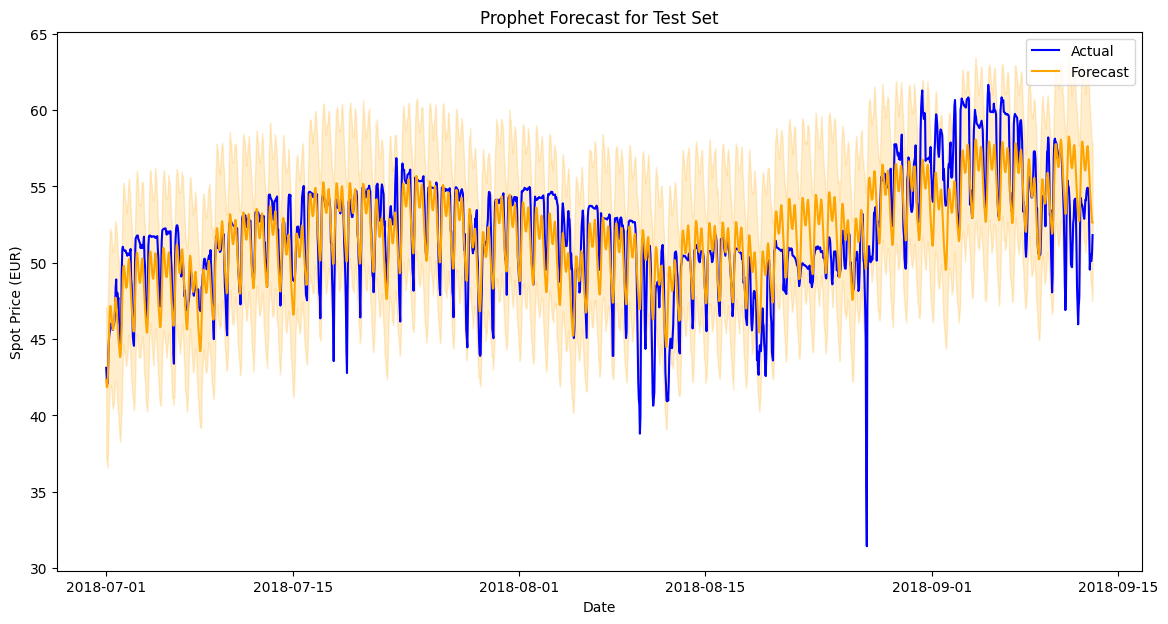

In [45]:
# plot forecast_test and test_prophet
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(test_prophet['ds'], test_prophet['y'], label='Actual', color='blue')
ax.plot(forecast_test['ds'], forecast_test['yhat'], label='Forecast', color='orange')
ax.fill_between(forecast_test['ds'], forecast_test['yhat_lower'], forecast_test['yhat_upper'], color='orange', alpha=0.2)
ax.set_title('Prophet Forecast for Test Set')
ax.set_xlabel('Date')
ax.set_ylabel('Spot Price (EUR)')
ax.legend()
plt.show()

ConversionError: Failed to convert value(s) to axis units: '2018-01-01'

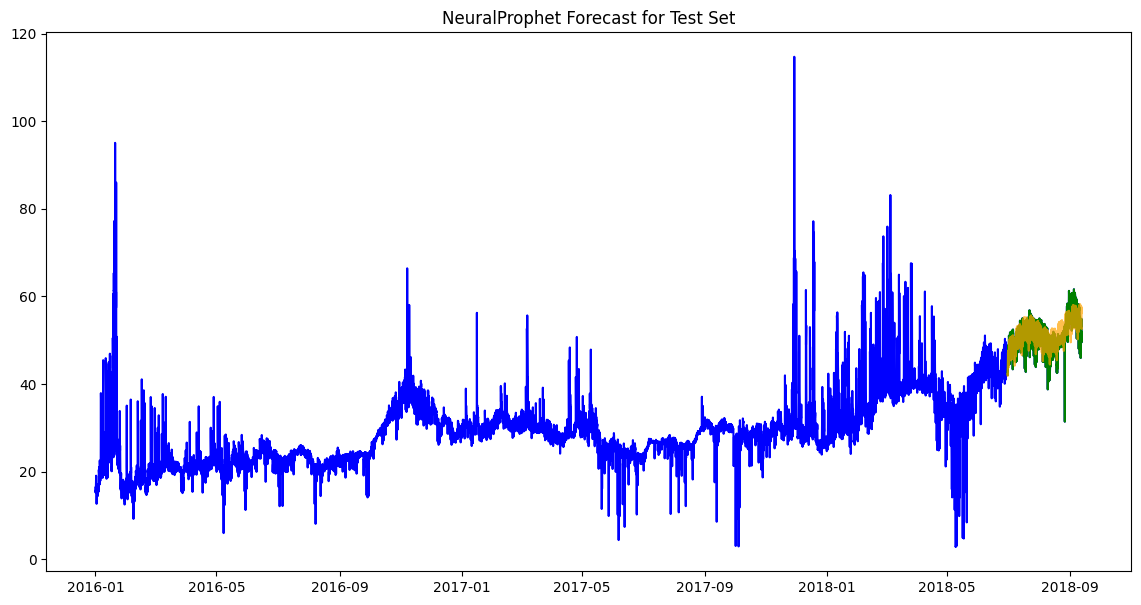

In [ ]:
# plot train and test data
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(data_prophet['ds'], data_prophet['y'], label='Train', color='blue')
ax.plot(test_prophet['ds'], test_prophet['y'], label='Test', color='green')
ax.plot(forecast_test['ds'], forecast_test['yhat'], label='Forecast', color='orange', alpha=0.7)
ax.set_title('NeuralProphet Forecast for Test Set')

plt.show()

## Neural Prophet

In [46]:
from neuralprophet import NeuralProphet, set_log_level

# Disable logging messages unless there is an error
set_log_level("ERROR")

# Create a NeuralProphet model with default parameters
m = NeuralProphet()
# Use static plotly in notebooks
m.set_plotting_backend("plotly-static")

# Fit the model on the dataset (this might take a bit)
metrics = m.fit(data_prophet)

Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/259 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

In [47]:
df_future = m.make_future_dataframe(data_prophet, n_historic_predictions=True, periods=365)

# Predict the future
forecast = m.predict(df_future)



Predicting: |          | 0/? [00:00<?, ?it/s]

In [48]:
forecast_test_nn = forecast[(forecast['ds'] >= test_prophet['ds'].min()) & (forecast['ds'] <= test_prophet['ds'].max())]

In [49]:
forecast_test_nn

,ds,y,yhat1,trend,season_yearly,season_weekly,season_daily
21887,2018-07-01 00:00:00,43.12,42.436569,48.040592,-0.962053,-2.054726,-2.587247
21888,2018-07-01 01:00:00,42.36,41.834225,48.044788,-0.954844,-2.084278,-3.171440
21889,2018-07-01 02:00:00,42.06,41.837074,48.048985,-0.948053,-2.105344,-3.158513
21890,2018-07-01 03:00:00,42.33,42.755882,48.053181,-0.940459,-2.117975,-2.238865
21891,2018-07-01 04:00:00,44.16,44.123806,48.057377,-0.933141,-2.121258,-0.879175
...,...,...,...,...,...,...,...
23661,2018-09-12 22:00:00,50.53,54.539101,55.485271,0.146714,0.481247,-1.574133
23662,2018-09-12 23:00:00,50.12,54.102859,55.489464,0.145302,0.476338,-2.008244
23663,2018-09-13 00:00:00,50.12,53.509544,55.493664,0.143905,0.471916,-2.599943
23664,2018-09-13 01:00:00,50.65,52.944481,55.497856,0.142460,0.467127,-3.162958


In [50]:
# calculate RMSE
rmse = mean_squared_error(test_prophet['y'], forecast_test_nn['yhat1'], squared=False)
print(f'RMSE: {rmse:.2f} EUR')

RMSE: 2.87 EUR


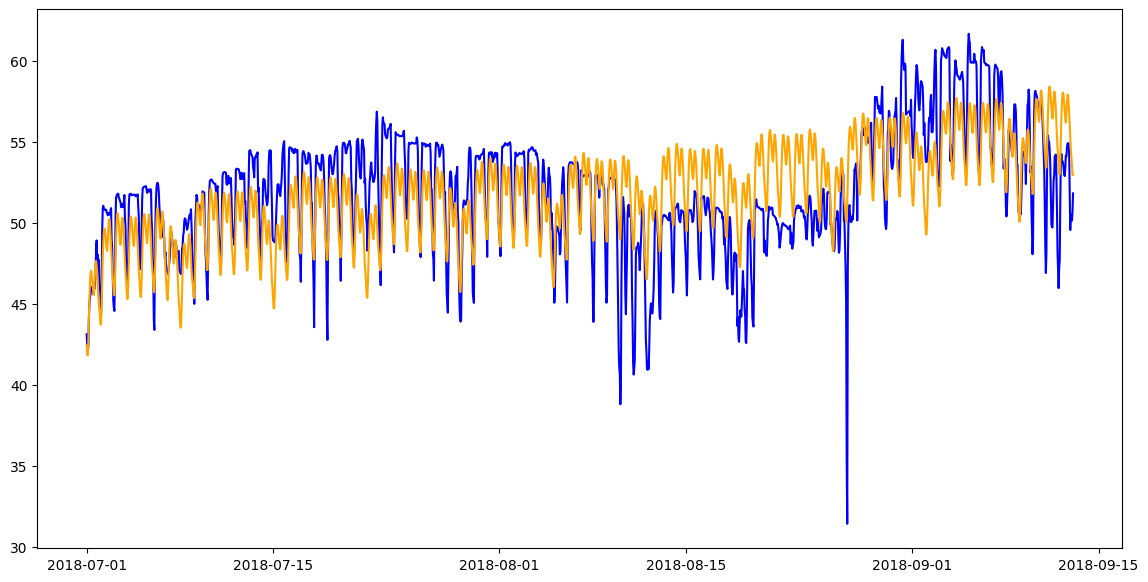

In [51]:
# plot forecast_test and test_prophet
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(test_prophet['ds'], test_prophet['y'], label='Actual', color='blue')
ax.plot(forecast_test_nn['ds'], forecast_test_nn['yhat1'], label='Forecast', color='orange')
plt.show()

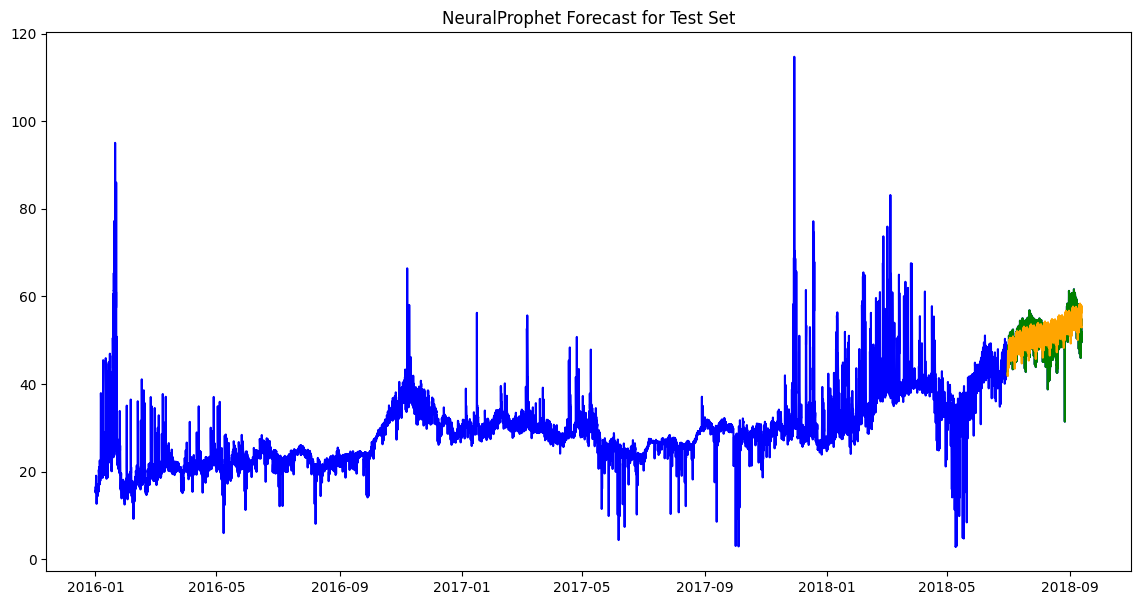

In [55]:
# plot train and test data
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(data_prophet['ds'], data_prophet['y'], label='Train', color='blue')
ax.plot(test_prophet['ds'], test_prophet['y'], label='Test', color='green')
ax.plot(forecast_test_nn['ds'], forecast_test_nn['yhat1'], label='Forecast', color='orange')
ax.set_title('NeuralProphet Forecast for Test Set')

plt.show()